Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

C:\Users\conno\.virtualenvs\DS-Unit-4-Sprint-1-NLP-Y17kEYKC\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [3]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

def tokenize(text):
    "Complete this function"
    
    return [token for token in simple_preprocess(text) if token in STOPWORDS]

In [4]:
import os

def gather_data(path_to_data): 
    data = []
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))       
    return data

In [5]:
tokens = gather_data(path)

In [6]:
tokens[0][0:10]

['by', 'and', 'with', 'and', 'seemed', 'to', 'some', 'of', 'the', 'of']

In [7]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [8]:
df['tokens'].head()

NameError: name 'df' is not defined

## Follow Along

In [9]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [10]:
len(titles)

813

In [11]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [12]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

In [13]:
len(tokens)

813

### Author DataFrame


In [14]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [15]:
df.head()

,tokens
Austen_Emma0000,"[by, and, with, and, seemed, to, some, of, the..."
Austen_Emma0001,"[she, were, here, again, what, it, is, that, e..."
Austen_Emma0002,"[all, every, was, every, in, their, not, and, ..."
Austen_Emma0003,"[of, and, of, which, for, the, last, two, or, ..."
Austen_Emma0004,"[some, of, the, had, you, have, of, the, has, ..."


In [16]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [17]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [18]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [19]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(str(text))
                yield tokens

In [26]:
streaming_data = doc_stream(path)

In [21]:
# gather_data => returns a list
# doc_stream => returns a generator

In [27]:
next(streaming_data) # Returns one document at a time from the generator

<generator object doc_stream at 0x000001A919BD1E58>


### Gensim LDA Topic Modeling

In [28]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [37]:
id2word.token2id['girl']

638

In [40]:
id2word[869]

'england'

In [39]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(869, 3), (1254, 1), (2485, 1), (16850, 1)]

In [41]:
import sys
sys.getsizeof(id2word)

56

In [42]:
len(id2word.keys())

22095

In [10]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [50]:
len(id2word.keys())

8102

In [12]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [52]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1)]

In [53]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

In [54]:
lda.print_topics()

[(0,
  '0.009*"pounds" + 0.007*"mother" + 0.006*"sure" + 0.006*"think" + 0.006*"year" + 0.004*"rochester" + 0.004*"certainly" + 0.004*"thornfield" + 0.004*"fairfax" + 0.004*"live"'),
 (1,
  '0.008*"pelet" + 0.005*"thought" + 0.005*"like" + 0.004*"little" + 0.004*"man" + 0.004*"hunsden" + 0.004*"time" + 0.003*"having" + 0.003*"pupils" + 0.003*"crimsworth"'),
 (2,
  '0.008*"madame" + 0.006*"little" + 0.006*"like" + 0.004*"day" + 0.004*"vous" + 0.004*"thought" + 0.003*"know" + 0.003*"beck" + 0.003*"good" + 0.003*"paul"'),
 (3,
  '0.005*"night" + 0.005*"look" + 0.005*"like" + 0.004*"old" + 0.004*"est" + 0.004*"looked" + 0.003*"sir" + 0.003*"thought" + 0.003*"house" + 0.003*"hunsden"'),
 (4,
  '0.007*"little" + 0.005*"madame" + 0.005*"like" + 0.004*"thought" + 0.004*"know" + 0.004*"hand" + 0.004*"good" + 0.004*"night" + 0.003*"day" + 0.003*"dr"'),
 (5,
  '0.017*"elizabeth" + 0.013*"darcy" + 0.010*"miss" + 0.010*"bingley" + 0.010*"bennet" + 0.009*"jane" + 0.007*"know" + 0.007*"think" + 0.006

In [55]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [56]:
topics = [' '.join(t[0:5]) for t in words]

In [63]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
pounds mother sure think year

------ Topic 1 ------
pelet thought like little man

------ Topic 2 ------
madame little like day vous

------ Topic 3 ------
night look like old est

------ Topic 4 ------
little madame like thought know

------ Topic 5 ------
elizabeth darcy miss bingley bennet

------ Topic 6 ------
know jane life like long

------ Topic 7 ------
frances monsieur hunsden little english

------ Topic 8 ------
good little like emma elton

------ Topic 9 ------
sir long jane rochester little

------ Topic 10 ------
like little rochester miss room

------ Topic 11 ------
emma miss harriet thing weston

------ Topic 12 ------
jane emma little thing miss

------ Topic 13 ------
elinor marianne sister mother time

------ Topic 14 ------
monsieur henri georgiana mdlle little



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [29]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [30]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

NameError: name 'lda' is not defined

### Overall Model / Documents

In [66]:
lda[corpus[0]]

[(10, 0.13784581), (11, 0.7755074), (13, 0.084544025)]

In [67]:
distro = [lda[d] for d in corpus]

In [70]:
distro[0]

[(10, 0.13785432), (11, 0.7755409), (13, 0.08450204)]

In [71]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [72]:
len(new_distro)

813

In [73]:
df.head()

,tokens,author,book,section
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ...",1,Emma,26
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di...",1,Emma,32
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu...",0,Villette,86
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s...",0,Jane,99
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn...",0,Villette,92


In [74]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [75]:
df.head()

,pounds mother sure think year,pelet thought like little man,madame little like day vous,night look like old est,little madame like thought know,elizabeth darcy miss bingley bennet,know jane life like long,frances monsieur hunsden little english,good little like emma elton,sir long jane rochester little,like little rochester miss room,emma miss harriet thing weston,jane emma little thing miss,elinor marianne sister mother time,monsieur henri georgiana mdlle little,author
Austen_Emma0026,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.137813,0.775376,0.0,0.084708,0.0,Austen
Austen_Emma0032,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.997455,0.0,0.000000,0.0,Austen
CBronte_Villette0086,0.0,0.0,0.0,0.0,0.215017,0.000000,0.782771,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,CBronte
CBronte_Jane0099,0.0,0.0,0.0,0.0,0.000000,0.000000,0.522729,0.0,0.0,0.0,0.473159,0.000000,0.0,0.000000,0.0,CBronte
CBronte_Villette0092,0.0,0.0,0.0,0.0,0.561909,0.027238,0.000000,0.0,0.0,0.0,0.370953,0.038246,0.0,0.000000,0.0,CBronte


In [76]:
df.groupby('author').mean()

,pounds mother sure think year,pelet thought like little man,madame little like day vous,night look like old est,little madame like thought know,elizabeth darcy miss bingley bennet,know jane life like long,frances monsieur hunsden little english,good little like emma elton,sir long jane rochester little,like little rochester miss room,emma miss harriet thing weston,jane emma little thing miss,elinor marianne sister mother time,monsieur henri georgiana mdlle little
author,,,,,,,,,,,,,,,
Austen,0.002680,0.005265,0.000558,0.000027,0.002224,0.229068,0.005129,0.000833,0.016319,0.005213,0.014229,0.352142,0.023068,0.340476,0.000000
CBronte,0.002808,0.035886,0.061154,0.008203,0.298078,0.005798,0.123300,0.026866,0.007873,0.012273,0.385653,0.005757,0.004657,0.014485,0.004485


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [15]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [ ]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [79]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [80]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.603344,2,0
1,-0.859198,8,0
2,-0.821042,14,0
3,-0.710456,20,0
4,-0.843094,26,0


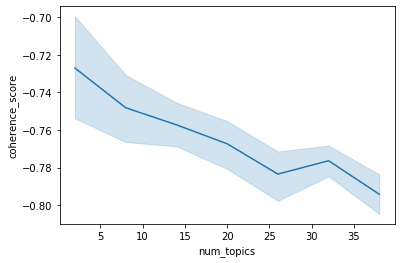

In [82]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [84]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [ ]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [85]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [86]:
test = "Ned asked me a question about England today."

In [87]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [88]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [89]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            with open(os.path.join(path,f)) as t:
                text = t.read().strip('\n')
                yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [ ]:
%pwd

In [90]:
people = get_people(doc_stream(path))

In [ ]:
list(people)[:50]

In [ ]:
gender_lookup = {'Adele':'female_charc', 'William Crimsworth':'male_charc'}

In [ ]:
doc = nlp(next(doc_stream(path)))

In [ ]:
doc.ents[0].lemma_

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)